<a href="https://colab.research.google.com/github/slunara/ratDetectorComputerVision/blob/main/NewData_auto_anotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Rat Detector

Susana Luna - Computer Vision - Individual Assignment

Objective: Build a Rat Detector using YOLOv10 model and automatic annotation using GroundingDINO.



Let's make sure that we have access to GPU.

In [ ]:
#!ls -lah /content/

total 16K
drwxr-xr-x 1 root root 4.0K Feb  8 10:38 .
drwxr-xr-x 1 root root 4.0K Feb  8 10:00 ..
drwxr-xr-x 4 root root 4.0K Feb  6 14:19 .config


In [ ]:
!nvidia-smi

Mon Feb 10 10:00:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 1: Auto anotation

## Install libraries

- Grounding DINO
- Additional Deppendencies

In [ ]:
# we use latest Grounding DINO model API that is not official yet
import os
import torch
import glob
import cv2
from typing import List
from PIL import Image
import imghdr

<ipython-input-2-9eb53ea286e1>:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric


/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
M	groundingdino/version.py
Already on 'feature/more_compact_inference_api'
Your branch is up to date with 'origin/feature/more_compact_inference_api'.
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
roboflow: 1.1.53 ; supervision: 0.4.0


In [ ]:
# confirm that configuration file exist


CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
# confirm that weights file exist

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Download Raw Data

In [ ]:
!rm -rf /content/ratDetectorComputerVision  # Remove old repo (if needed)
!git clone https://github.com/slunara/ratDetectorComputerVision.git /content/ratDetectorComputerVision

Cloning into '/content/ratDetectorComputerVision'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (473/473), done.
remote: Total 475 (delta 12), reused 446 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (475/475), 10.35 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (12/12), done.


Check the raw images quantity

In [ ]:
image_folder = "/content/ratDetectorComputerVision/data"


image_extensions = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.gif", "*.tiff", "*.webp")
image_count = sum(len(glob.glob(os.path.join(image_folder, "**", ext), recursive=True)) for ext in image_extensions)

print(f"Total images on the folder: {image_count}")

Total images on the folder: 444


Change the image name to avoid problems in roboflow

In [ ]:
for filename in os.listdir(image_folder):
        if filename.startswith("rat_"):
            new_filename = filename.replace("rat_", "r_", 1)  # Replace only the first occurrence
            old_file_path = os.path.join(image_folder, filename)
            new_file_path = os.path.join(image_folder, new_filename)
            os.rename(old_file_path, new_file_path)

In [ ]:
image_folder = "/content/ratDetectorComputerVision/data"


image_extensions = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.gif", "*.tiff", "*.webp")
image_count = sum(len(glob.glob(os.path.join(image_folder, "**", ext), recursive=True)) for ext in image_extensions)

print(f"Total images on the folder: {image_count}")

Total images on the folder: 444


In [ ]:
print(os.listdir(image_folder))

['r_1185.jpg', 'r_879.jpg', 'r_839.jpg', 'r_11.jpg', 'r_822.jpg', 'r_704.jpg', 'r_865.jpg', 'r_810.jpg', 'r_883.jpg', 'r_1437.jpg', 'r_235.jpg', 'r_578.jpg', 'r_82.jpg', 'r_223.jpg', 'r_565.jpg', 'r_447.jpg', 'r_1291.jpg', 'r_1327.jpg', 'r_300.jpg', 'r_913.jpg', 'r_523.jpg', 'r_23.jpg', 'r_637.jpg', 'r_557.jpg', 'r_443.jpg', 'r_90.jpg', 'r_1099.jpg', 'r_1343.jpg', 'r_747.jpg', 'r_378.jpg', 'r_425.jpg', 'r_967.jpg', 'r_80.jpg', 'r_995.jpg', 'r_449.jpg', 'r_245.jpg', 'r_327.jpg', 'r_588.jpg', 'r_351.jpg', 'r_600.jpg', 'r_1249.jpg', 'r_284.jpg', 'r_253.jpg', 'r_129.jpg', 'r_147.jpg', 'r_1530.jpg', 'r_182.jpg', 'r_325.jpg', 'r_92.jpg', 'r_13.jpg', 'r_574.jpg', 'r_1107.jpg', 'r_1251.jpg', 'r_1153.jpg', 'r_639.jpg', 'r_43.jpg', 'r_897.jpg', 'r_8.jpg', 'r_57.jpg', 'r_645.jpg', 'r_188.jpg', 'r_104.jpg', 'r_651.jpg', 'r_276.jpg', 'r_1485.jpg', 'r_1465.jpg', 'r_576.jpg', 'r_306.jpg', 'r_667.jpg', 'r_204.jpg', 'r_1273.jpg', 'r_76.jpg', 'r_1399.jpg', 'r_498.jpg', 'r_812.jpg', 'r_1301.jpg', 'r_1313

## Load GoundingDINO model

In [ ]:
%cd {HOME}/GroundingDINO
#!pip install -e .
from groundingdino.util.inference import Model

/content/GroundingDINO


Importing from timm.models.layers is deprecated, please import via timm.layers


In [ ]:
model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allow

Check how it works with one image

In [ ]:
SOURCE_IMAGE_PATH = "/content/ratDetectorComputerVision/data/r_1465.jpg"
CLASSES = ['rat']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


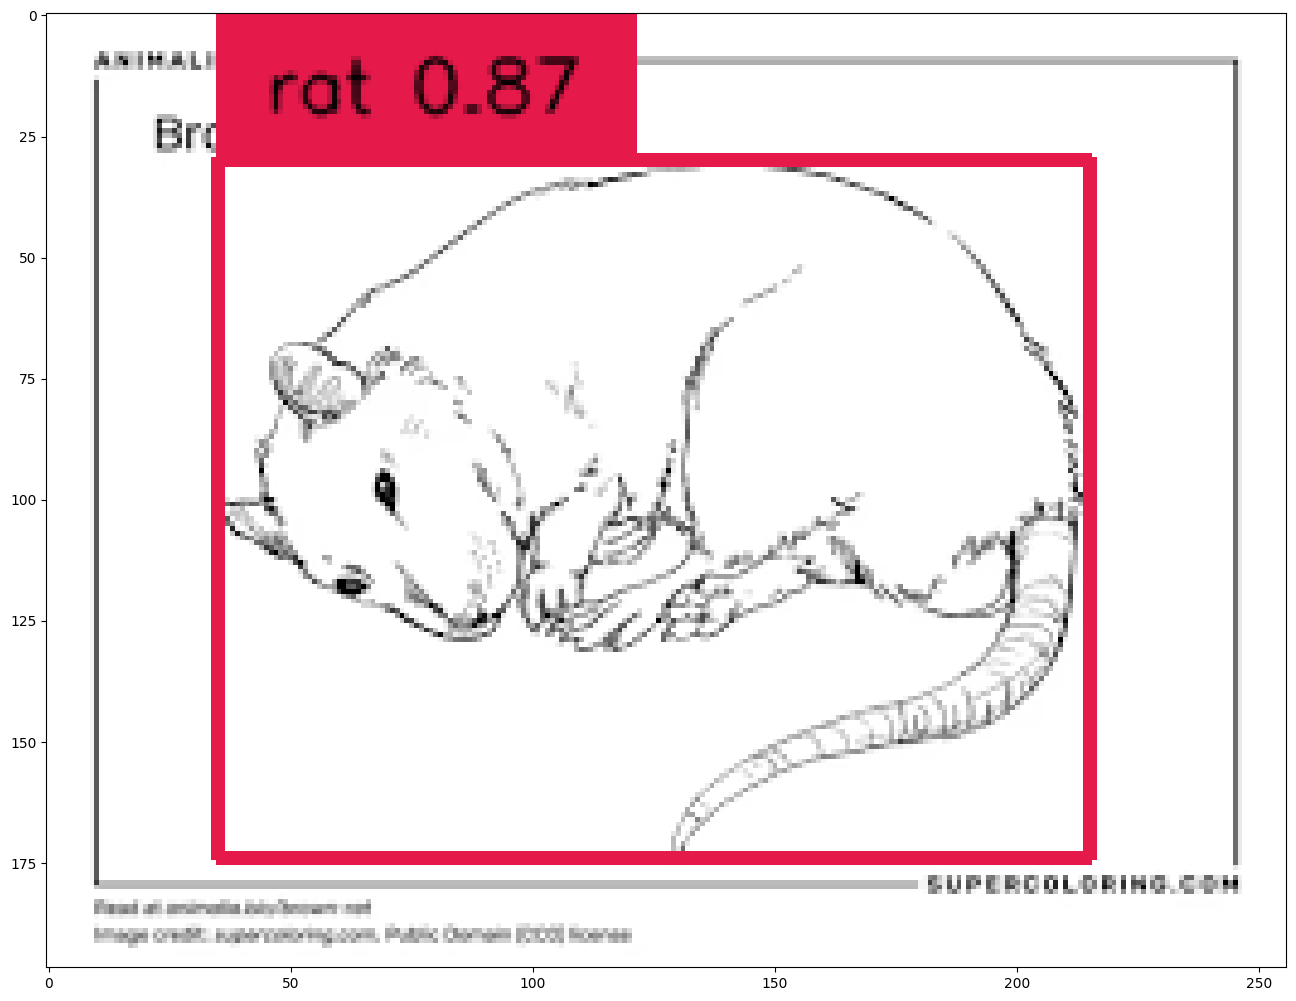

In [ ]:
import supervision as sv

image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Dataset auto anotation

In [ ]:
def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)


def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

In [ ]:
PROJECT_NAME = "ratsDetectionV3"
PROJECT_DESCRIPTION = "ratsClassification"
SOURCE_DIRECTORY_PATH = "/content/ratDetectorComputerVision/data"
CLASSES = ['rat']
BOX_TRESHOLD = 0.5
TEXT_TRESHOLD = 0.5

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")

workspace = rf.workspace()

new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation="BoundingBox-Annotations")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

Change images with PNG format to JPEG to match filename extension.

In [ ]:
image_path = "/content/ratDetectorComputerVision/data/r_1465.jpg"

try:
    with Image.open(image_path) as img:
        print(f"Actual format: {img.format}")
except Exception as e:
    print(f"Error: {e}")

Actual format: PNG


In [ ]:
image_dir = SOURCE_DIRECTORY_PATH


if not os.path.exists(image_dir):
    print(f"Directory '{image_dir}' not found!")
else:
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)

        if not os.path.isfile(file_path):
            continue

        actual_format = imghdr.what(file_path)

        # If the file is actually a PNG but doesn't have .png extension, print it
        if actual_format == "png" and not filename.lower().endswith(".png"):
            print(f"Incorrect PNG file: {filename} (should be .png)")

Incorrect PNG file: r_1465.jpg (should be .png)
Incorrect PNG file: r_812.jpg (should be .png)
Incorrect PNG file: r_102.jpg (should be .png)
Incorrect PNG file: r_59.jpg (should be .png)
Incorrect PNG file: r_241.jpg (should be .png)
Incorrect PNG file: r_1499.jpg (should be .png)
Incorrect PNG file: r_319.jpg (should be .png)


In [ ]:
image_dir = SOURCE_DIRECTORY_PATH


if not os.path.exists(image_dir):
    print(f"❌ Directory '{image_dir}' not found! Please check the path.")
else:

    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)


        if not os.path.isfile(file_path):
            continue


        actual_format = imghdr.what(file_path)

        if actual_format == "png":
            new_filename = os.path.splitext(filename)[0] + "_converted.jpg"  # Add '_converted' to avoid overwriting
            new_file_path = os.path.join(image_dir, new_filename)

            try:
                with Image.open(file_path) as img:
                    rgb_img = img.convert("RGB")  # Convert PNG (RGBA) to RGB
                    rgb_img.save(new_file_path, "JPEG")

                # Remove the old PNG file
                os.remove(file_path)
                print(f"✅ Converted: {filename} → {new_filename}")
            except Exception as e:
                print(f"❌ Error converting {filename}: {e}")


✅ Converted: r_1465.jpg → r_1465_converted.jpg
✅ Converted: r_812.jpg → r_812_converted.jpg
✅ Converted: r_102.jpg → r_102_converted.jpg
✅ Converted: r_59.jpg → r_59_converted.jpg
✅ Converted: r_241.jpg → r_241_converted.jpg
✅ Converted: r_1499.jpg → r_1499_converted.jpg
✅ Converted: r_319.jpg → r_319_converted.jpg


In [ ]:
image_path = "/content/ratDetectorComputerVision/data/r_1465_converted.jpg"

try:
    with Image.open(image_path) as img:
        print(f"🔍 Actual format: {img.format}")
except Exception as e:
    print(f"❌ Error: {e}")

🔍 Actual format: JPEG


In [ ]:
#from roboflow import Roboflow

# Initialize Roboflow API
#rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")  # Use your actual API key

# Try fetching the default workspace (if available)
#workspace = rf.workspace()

# Print workspace details
print(f"✅ Connected to Workspace: {workspace.name} (URL: {workspace.url})")


✅ Connected to Workspace: Computer Vision (URL: computer-vision-ps2op)


In [ ]:
# List all projects in your workspace
projects = workspace.projects()

print("\n📂 Available Projects in Workspace:")
for project in projects:
    print(f"- Project Name: {project}")  # Directly print project names



📂 Available Projects in Workspace:
- Project Name: computer-vision-ps2op/ratsdetectionv3


In [ ]:
new_project = workspace.project("ratsdetectionv3")  # Replace with the correct project
print(f"✅ Successfully loaded project: {new_project}")

loading Roboflow project...
✅ Successfully loaded project: {
  "name": "ratsDetectionV3",
  "type": "object-detection",
  "workspace": "computer-vision-ps2op"
}


In [ ]:
import os
import cv2
from roboflow import Roboflow

#from roboflow import Roboflow
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")

workspace = rf.workspace()

new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation="BoundingBox-Annotations")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
PROJECT_NAME

'ratsDetectionV3'

In [ ]:
rf = Roboflow(api_key="1bZDjhBKBgnisv5Hf2VR")
workspace = rf.workspace("computer-vision-ps2op")
project = workspace.project("ratsdetectionv3")


# Define paths and thresholds
SOURCE_DIRECTORY_PATH = "/content/ratDetectorComputerVision/data"
BOX_THRESHOLD = 0.5
TEXT_THRESHOLD = 0.5
CLASSES = ["rat"]

# Ensure output folder exists for annotations
ANNOTATION_DIR = os.path.join(SOURCE_DIRECTORY_PATH, "annotations")
os.makedirs(ANNOTATION_DIR, exist_ok=True)

# Loop through all images in the directory
for image_name in os.listdir(SOURCE_DIRECTORY_PATH):
    if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue  # Skip non-image files

    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"❌ Error: Unable to read {image_name}, skipping.")
        continue

    height, width, depth = image.shape

    # Run object detection on the image
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    # Filter detections
    detections = detections[detections.class_id != None]  # Remove null detections
    detections = detections[(detections.area / (height * width)) < 0.9]  # Remove large boxes
    # detections = detections.with_nms()  # Uncomment if needed to remove duplicate boxes

    # Generate XML annotation filename
    xml_name = os.path.splitext(image_name)[0] + ".xml"
    xml_path = os.path.join(ANNOTATION_DIR, xml_name)

    # Convert detections to PASCAL VOC XML format
    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    # Save XML annotation file
    with open(xml_path, "w") as xml_file:
        xml_file.write(xml_string)

    # Upload to Roboflow (Image + Annotation)
    try:
        new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)
        print(f"✅ Successfully uploaded {image_name} with annotation.")
    except Exception as e:
        print(f"❌ Error uploading {image_name}: {e}")


loading Roboflow workspace...
loading Roboflow project...
✅ Successfully uploaded r_1185.jpg with annotation.
✅ Successfully uploaded r_879.jpg with annotation.
✅ Successfully uploaded r_839.jpg with annotation.
✅ Successfully uploaded r_11.jpg with annotation.
✅ Successfully uploaded r_822.jpg with annotation.
✅ Successfully uploaded r_704.jpg with annotation.
✅ Successfully uploaded r_865.jpg with annotation.
✅ Successfully uploaded r_810.jpg with annotation.
✅ Successfully uploaded r_883.jpg with annotation.
✅ Successfully uploaded r_1437.jpg with annotation.
✅ Successfully uploaded r_235.jpg with annotation.
✅ Successfully uploaded r_578.jpg with annotation.
✅ Successfully uploaded r_82.jpg with annotation.
✅ Successfully uploaded r_223.jpg with annotation.
✅ Successfully uploaded r_565.jpg with annotation.
✅ Successfully uploaded r_447.jpg with annotation.
✅ Successfully uploaded r_1291.jpg with annotation.
✅ Successfully uploaded r_1327.jpg with annotation.
✅ Successfully uploade